#  REGRESIÓN LOGÍSTICA 
 ***
 <code> **SELECCIÓN DE VARIABLES** </code>


En este Notebook se desarrollará la de selección de variables del modelo de regresión logística.

In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
import numpy as np

In [2]:
data = pd.read_csv("datosEntrenamientoModelosFinal.csv")

In [3]:
data.head()

,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,...,World History,World War I,World War II,Writing,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
0,0.0,329.0,1.0,0.51,0.40,0,19.99,1.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,269.0,2.0,0.61,0.54,1,3.99,2.0,ebook,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2335.0,1.0,0.72,0.57,1,20.99,7.0,ebook,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,40.0,1.0,0.83,0.35,0,25.00,1.0,hardcover,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,189.0,1.0,0.59,0.26,0,15.00,4.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def getYX(df):
    return df.iloc[:,0], df.iloc[:,1:]

In [5]:
def codificarPriceFormat(df):
    return pd.get_dummies(df, columns=['PriceFormat'], dtype = int)

In [6]:
SEED = 22
CV_FOLDS = 5

### ESCALADO ROBUSTO DE VARIABLES NUMÉRICAS

In [7]:
data.columns[:20]

Index(['Bestseller', 'NumPages', 'SagaNumber', 'RedPerc', 'BluePerc',
       'BelongsSaga', 'Price', 'WordsTitle', 'PriceFormat', 'BookInterest1M',
       'Rating20Days', 'HasTwitter', 'HasWikipedia', 'PrevBestSellAuthor',
       '19th Century', '20th Century', 'Abuse', 'Action', 'Adoption', 'Adult'],
      dtype='object')

In [8]:
variablesNumericas = ['NumPages', 'SagaNumber', 'RedPerc', 'BluePerc', 'Price', 'WordsTitle', 'BookInterest1M',
                     'Rating20Days', 'PrevBestSellAuthor']

In [9]:
data[variablesNumericas].describe()

,NumPages,SagaNumber,RedPerc,BluePerc,Price,WordsTitle,BookInterest1M,Rating20Days,PrevBestSellAuthor
count,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000
mean,356.830894,1.791870,0.479629,0.426317,18.327837,3.272358,214.985908,4.113350,0.543089
std,118.741723,3.281587,0.230449,0.204710,5.715308,1.597749,430.073990,0.368062,3.646394
min,11.000000,0.000000,0.010000,0.010000,0.990000,1.000000,0.000000,2.000000,0.000000
25%,304.000000,1.000000,0.290000,0.260000,14.990000,2.000000,0.000000,3.880000,0.000000
50%,350.000000,1.000000,0.460000,0.400000,17.390000,3.000000,100.000000,4.140000,0.000000
75%,400.000000,1.000000,0.670000,0.580000,21.007500,4.000000,180.000000,4.370000,0.000000
max,2895.000000,58.000000,0.990000,0.940000,68.490000,14.000000,2911.000000,5.000000,48.000000


In [10]:
scaler = RobustScaler()

# Aplicamos el RobustScaler
for var in variablesNumericas:
    data[var] = scaler.fit_transform(data[var].values.reshape(-1, 1))

In [11]:
data[variablesNumericas].describe()

,NumPages,SagaNumber,RedPerc,BluePerc,Price,WordsTitle,BookInterest1M,Rating20Days,PrevBestSellAuthor
count,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000,3690.000000
mean,0.071155,0.791870,0.051655,0.082241,0.155852,0.136179,0.638811,-0.054389,0.543089
std,1.236893,3.281587,0.606445,0.639719,0.949781,0.798874,2.389300,0.751146,3.646394
min,-3.531250,-1.000000,-1.184211,-1.218750,-2.725384,-1.000000,-0.555556,-4.367347,0.000000
25%,-0.479167,0.000000,-0.447368,-0.437500,-0.398837,-0.500000,-0.555556,-0.530612,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.520833,0.000000,0.552632,0.562500,0.601163,0.500000,0.444444,0.469388,0.000000
max,26.510417,57.000000,1.394737,1.687500,8.491899,5.500000,15.616667,1.755102,48.000000


### 2. Recursive feature elimination con validación cruzada

In [12]:
from imblearn.pipeline import make_pipeline

In [13]:
def aplicarRFECV(X, y):
    
    MIN_FEATURES = 5
    METRICA = "balanced_accuracy"

    # Modelo de regresión logística
    modelo = LogisticRegression(max_iter = 5000, class_weight="balanced")

    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)
   
    rfecv = RFECV(
        estimator=modelo,
        step=1,
        cv=cv,
        scoring=METRICA,
        min_features_to_select= MIN_FEATURES,
    )
    
    rfecv.fit(X, y)
    
    # Número óptimo de variables seleccionadas
    num_optimal_features = rfecv.n_features_
    print("Número óptimo de variables seleccionadas:", num_optimal_features)

    # Obtener índices de variables seleccionadas
    selected_feature_indices = rfecv.support_

    # Obtener nombres de variables seleccionadas
    selected_feature_names = [X.columns[i] for i, selected in enumerate(selected_feature_indices) if selected]
    
    # Tomado de https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure(figsize=(12, 6))
    plt.xlabel("Número de variables elegidas")
    plt.ylabel("Media balanced accuracy en test")
    plt.errorbar(
        range(MIN_FEATURES, n_scores + MIN_FEATURES),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("RFE con validación cruzada")
    plt.show()
    
    return selected_feature_names

Número óptimo de variables seleccionadas: 277


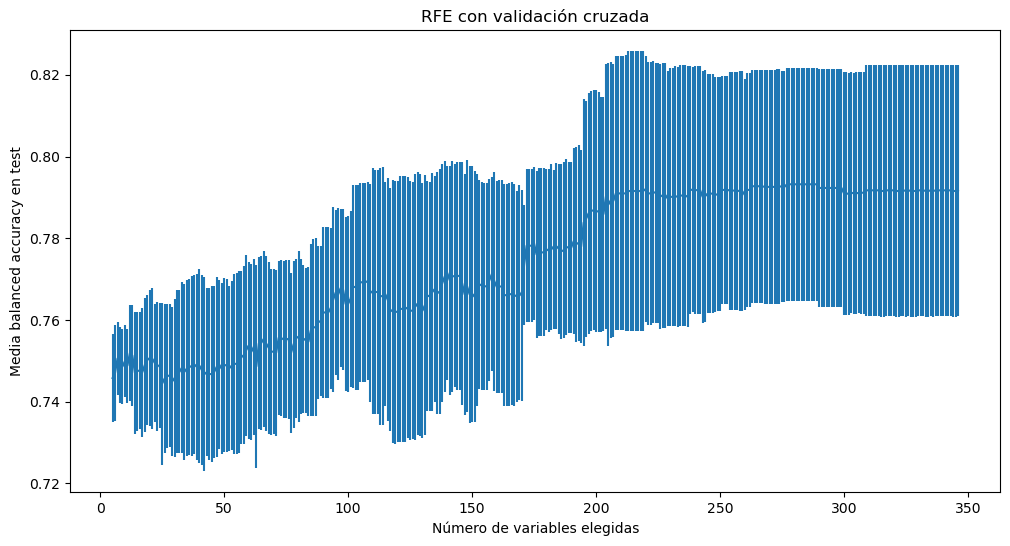

In [14]:
y, X = getYX(data)
X = codificarPriceFormat(X)

variablesElegidas = aplicarRFECV(X, y)

In [15]:
variablesDescartadas = [v for v in X.columns if v not in variablesElegidas]

In [16]:
print("--- VARIABLES SELECCIONADAS ---")
print(variablesElegidas)

print("--- VARIABLES DESCARTADAS ---")
print(variablesDescartadas)

--- VARIABLES SELECCIONADAS ---
['RedPerc', 'BluePerc', 'BelongsSaga', 'Price', 'WordsTitle', 'BookInterest1M', 'Rating20Days', 'HasTwitter', 'HasWikipedia', 'PrevBestSellAuthor', '19th Century', 'Abuse', 'Action', 'Adoption', 'Adult', 'Adult Fiction', 'Adventure', 'Africa', 'African American', 'African American Romance', 'African Literature', 'Aliens', 'Amazon', 'American', 'American History', 'Americana', 'Amish', 'Angels', 'Animals', 'Anthologies', 'Apocalyptic', 'Art', 'Asia', 'Asian Literature', 'Audiobook', 'Australia', 'Autistic Spectrum Disorder', 'BDSM', 'Banned Books', 'Biography', 'Biography Memoir', 'Book Club', 'Books About Books', 'Botswana', 'Boys Love', 'British Literature', 'Buisness', 'Bulgaria', 'Bulgarian Literature', 'Business', 'Canada', 'Chess', 'Chick Lit', 'Childrens', 'China', 'Christian Fiction', 'Christmas', 'Civil War', 'Classic Literature', 'Classics', 'Clean Romance', 'Climate Change', 'Climate Change Fiction', 'College', 'Comedy', 'Comic Book', 'Comics',

In [17]:
# Variables que superaron el test chi2
superanChi2 = ['HasWikipedia','History','Biography','Memoir','Self Help','Psychology','Classics','Personal Development','Detective','Crime','Business','Politics','Sociology','Leadership','Biography Memoir','BelongsSaga','Adventure','Science','Book Club','Health','LGBT','Military Fiction','Contemporary','True Crime','Childrens','Queer','Angels','Spy Thriller','Romance','Literature','Dogs','Autobiography','Superheroes','Horror','Paranormal Romance','BDSM','Action','Fantasy Romance','Gothic','Poetry','Erotica','Nature','Science Fiction Fantasy','Contemporary Romance','Retellings','School','Christianity','Economics','Military Science Fiction','Environment','Polish Literature','Botswana','Russian Literature','Relationships','Theology','Spirituality','Adult','Feminism','HasTwitter','Realistic Fiction','Lesbian','Middle Grade','American History','Fiction','Audiobook','Adult Fiction','Westerns','Family','Teen','Russia','Medieval','Military Romance','Epic','Social Justice','Plays','Gender','Post Apocalyptic','Entrepreneurship','Faith','Technology','Writing','Parenting','Horses','Football','Theatre','World History','Management','Mathematics','Productivity','Star Wars','Nursery Rhymes','Storytime','Journalism','Basketball','Classic Literature','Computers','Christian Living','Cookbooks','Design','Chess','Buisness','Biology','Communication','Banned Books','Apple','Cozy Mystery','Asian Literature','Novella','Art','PriceFormat_paperback','Psychological Thriller','France','Mythology','Young Adult Fantasy','Amazon','Witches','Science Fiction','Historical Romance','Abuse','Holocaust','Christian','Aliens']

In [20]:
descartadasChi2 = [v for v in variablesDescartadas if v in superanChi2]
print(len(descartadasChi2))
print(descartadasChi2)

25
['Apple', 'Autobiography', 'Basketball', 'Biology', 'Christian', 'Christian Living', 'Christianity', 'Communication', 'Computers', 'Cookbooks', 'Design', 'Economics', 'Entrepreneurship', 'Faith', 'Horses', 'Journalism', 'LGBT', 'Mathematics', 'Memoir', 'Productivity', 'Social Justice', 'Spirituality', 'Technology', 'World History', 'Writing']
